# CNN & ImageGenerator: Classifying Horses or Humans

Welcome to a new CNN project!

In this project, we are going to build a Convolutional Neural Network, with using ImageGenerator from Keras for data preprocessing, to classify pictures as horse or human.


## Table of Contents
- [1 - Set up the working directory & Import packages ](#1)
- [2 - Locate the dataset](#2)
- [3 - Preprocess the dataset](#3)
    - [Reshape the training and test data sets](#pre-1)
    - [Normalize the training and test data sets](#pre-2)
- [4 - Build the model](#4)
    - [4.1 - Define the model structure](#4-1)
    - [4.2 - Specify the training configuration](#4-2)
    - [4.3 - Train the model](#4-3)
- [5 - Improve the model to avoid overfitting](#5)
    - [5.1 - Create new ImageDataGenerators & Do Image Augmentation](#5-1)
    - [5.2 - Rebuild the model with Simple Dense Layers](#5-2)
- [6 - Test with new images](#6)
- [7- Visualize Intermediate Representations](#7)

<a name='1'></a>
## 1 - Set up the working directory & Import packages ##

In [2]:
# Move to the working directory on Google Drive as using Google Colab
import os

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  PROJECT_ROOT ="/content/drive/MyDrive/GitHub/CNN-ImageGenerator-Classifying-Horses-or-Humans"
  os.chdir(PROJECT_ROOT)
  !pwd
else:
  PROJECT_ROOT ="."

Running on CoLab
/content/drive/MyDrive/GitHub/CNN-ImageGenerator-Classifying-Horses-or-Humans


In [3]:
# View Nvidia CUDA drivers
!nvidia-smi

Thu Sep  2 05:08:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline


<a name='2'></a>
## 2 - Locate the dataset ##

The given dataset containing:
- a 'training' directory containing a 'horses' directory with horse images and a 'humans' directory with human images.
- 'validation' directory containing a 'horses' directory with horse images and a 'humans' directory with human images.
- Note that ImageGenerator wil be used later to read images from the subdirectories, and automatically label them from the name of that subdirectory.

In [5]:
# Directory for training images
train_dir = os.path.join(PROJECT_ROOT + '/datasets/training-horse-or-human')

# Directory with our training horse pictures
train_horse_dir = os.path.join(train_dir +'/horses')

# Directory with our training human pictures
train_human_dir = os.path.join(train_dir +'/humans')

# Directory for validation images
validation_dir = os.path.join(PROJECT_ROOT + '/datasets/validation-horse-or-human')

# Directory with our validation horse pictures
validation_horse_dir = os.path.join(validation_dir +'/horses')

# Directory with our validation human pictures
validation_human_dir = os.path.join(validation_dir +'/humans')

Let's find out the total number of horse and human images in the directories:

In [6]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))
print('total validation horse images:', len(os.listdir(validation_horse_dir)))
print('total validation human images:', len(os.listdir(validation_human_dir)))

total training horse images: 500
total training human images: 527
total validation horse images: 128
total validation human images: 128


Now, let's see what the first 5 filenames look like in the `horses` and `humans` training directories:

In [7]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:5])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:5])

validation_horse_hames = os.listdir(validation_horse_dir)
print(validation_horse_hames[:5])

validation_human_names = os.listdir(validation_human_dir)
print(validation_human_names[:5])

['horse09-5.png', 'horse11-5.png', 'horse18-9.png', 'horse50-7.png', 'horse27-7.png']
['human05-02.png', 'human03-02.png', 'human01-20.png', 'human02-05.png', 'human04-01.png']
['horse3-099.png', 'horse1-384.png', 'horse4-556.png', 'horse2-011.png', 'horse5-060.png']
['valhuman01-22.png', 'valhuman05-09.png', 'valhuman02-10.png', 'valhuman04-16.png', 'valhuman01-24.png']


Now let's take a look at a few pictures (a batch of 8 horse and 8 human pictures) to get a better sense of what they look like. 

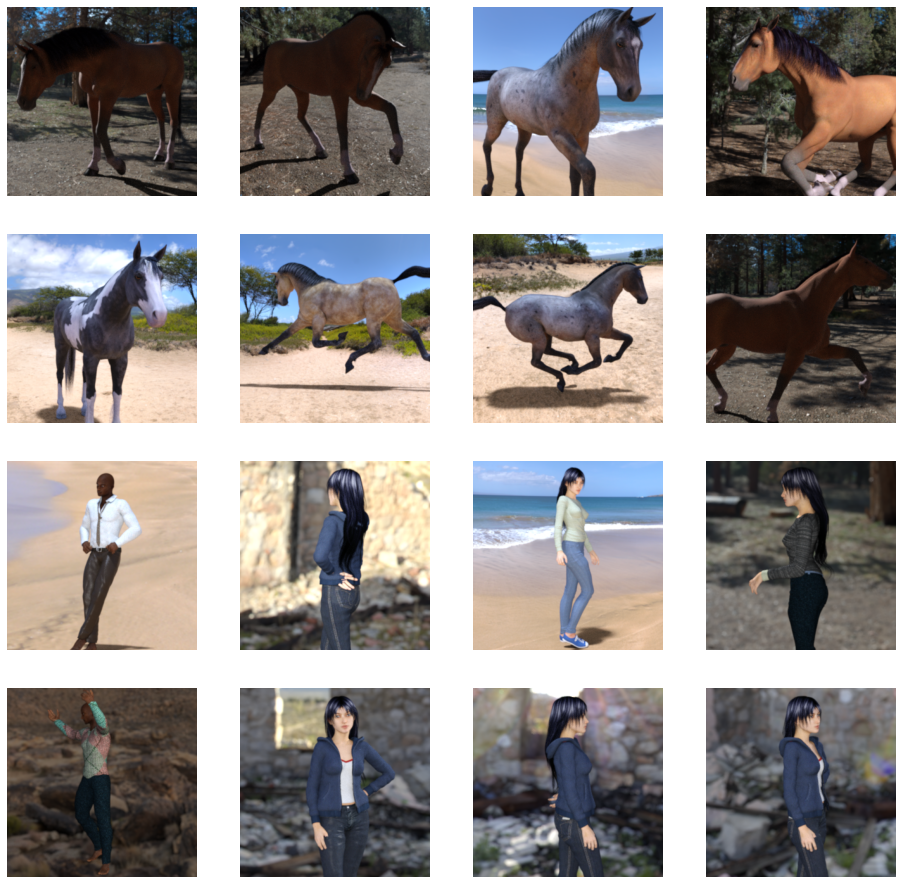

In [8]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


<a name='3'></a>
## 3 - Preprocess the dataset ##

Let's set up two ImageDataGenerators: one for the training images and one for the validation images. Each generator will read pictures in our source folders, convert the pictures to `float32` tensors, normalize them, and yield batches of images of size 300x300 and their (binary) labels.


In [22]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,  # This is the source directory for training images
    target_size=(300, 300),  # All images will be resized to 300x300
    batch_size=128,
    class_mode='binary', # Since we use binary_crossentropy loss, we need binary labels
    )

# Flow validation images in batches of 32 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        validation_dir, 
        target_size=(300, 300),  
        batch_size=32,
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


<a name='4'></a>
## 4 - Build the model ## 

<a name='4-1'></a>
### 4.1 - Define the model structure

Reminding the concept of Convolutional Neural Networks:
- Add some layers to do convolution before you have the dense 
layers, and then the information going to the dense layers is more focussed, and possibly more accurate.

In [23]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# print a summary of the NN
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 33, 33, 64)       

The "output shape" column shows how the size of the feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

<a name='4-2'></a>
### 4.2 - Specify the training configuration

- optimizer: [`rmsprop`](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) with a learning rate of `0.001`.
- loss: `binary_crossentropy`, because it's a binary classification problem and our final activation is a sigmoid. 
- metrics: `accuracy`.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

<a name='4-3'></a>
### 4.3 - Train the model

Let's train for 15 epochs -- this may take a few minutes to run.

Do note the values per epoch.

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. 

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 258s 32s/step - loss: 0.7711 - accuracy: 0.5562 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 10s 1s/step - loss: 0.6739 - accuracy: 0.6930 - val_loss: 1.7058 - val_accuracy: 0.5000
Epoch 3/15
8/8 [==============================] - 10s 1s/step - loss: 0.7910 - accuracy: 0.6841 - val_loss: 0.5277 - val_accuracy: 0.8398
Epoch 4/15
8/8 [==============================] - 11s 1s/step - loss: 0.4606 - accuracy: 0.8516 - val_loss: 0.5447 - val_accuracy: 0.7617
Epoch 5/15
8/8 [==============================] - 10s 1s/step - loss: 0.2209 - accuracy: 0.9433 - val_loss: 1.3082 - val_accuracy: 0.8125
Epoch 6/15
8/8 [==============================] - 10s 1s/step - loss: 0.0771 - accuracy: 0.9722 - val_loss: 0.9843 - val_accuracy: 0.8398
Epoch 7/15
8/8 [==============================] - 10s 1s/step - loss: 0.1275 - accuracy: 0.9511 - val_loss: 1.1320 - val_accuracy: 0.7773
Epoch 8/15
8/8 [================

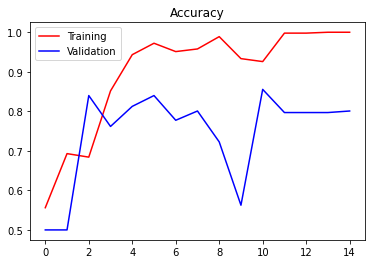

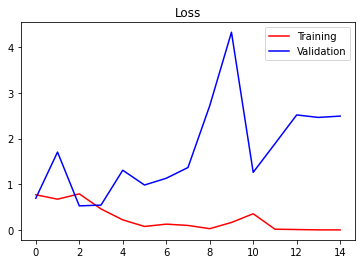

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Loss')
plt.legend()

plt.show()

<a name='5'></a>
## 5 - Improve the model to avoid overfitting ## 

<a name='5-1'></a>
### 5.1 - Create new ImageDataGenerators & Do Image Augmentation

**Note**: the image augmentation is only applied for the training set. 

In [10]:
# Create ImageDataGenerators and do Image Augmentation for the training set
train_datagen_1 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

validation_datagen_1 = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator_1 = train_datagen_1.flow_from_directory(
    train_dir, 
    target_size=(300, 300),
    batch_size=128,
    class_mode='binary',
    )

# Flow validation images in batches of 32 using validation_datagen generator
validation_generator_1 = validation_datagen_1.flow_from_directory(
        validation_dir, 
        target_size=(300, 300),  
        batch_size=32,
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


<a name='5-2'></a>
### 5.2 - Rebuild the model with Simple Dense Layers

In [11]:
# Define a new model with Dropout layer
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    #tf.keras.layers.Normalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    #tf.keras.layers.Normalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.Normalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.Normalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.Normalization(),
    tf.keras.layers.MaxPooling2D(2,2),
   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# print a summary of the NN
print(model_1.summary())

# Compile Model. 
model_1.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy']) 

# Train the Model
history_1 = model_1.fit(
      train_generator_1,
      steps_per_epoch=8,  
      epochs=60,
      verbose=1,
      validation_data = validation_generator_1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

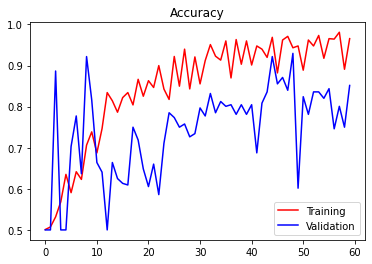

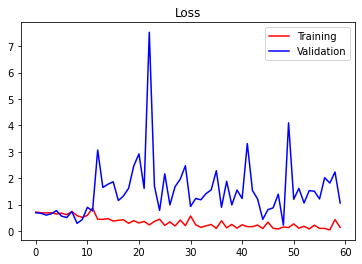

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']
loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'r', label='Training')
plt.plot(epochs, val_acc_1, 'b', label='Validation')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss_1, 'r', label='Training')
plt.plot(epochs, val_loss_1, 'b', label='Validation')
plt.title('Loss')
plt.legend()

plt.show()

<a name='6'></a>
## 6 - Test with new images

Let's now take a look at actually running  predictions for the images in the `images` folder using the model.


horse1.jpeg: Predicted Class = 1 => Human


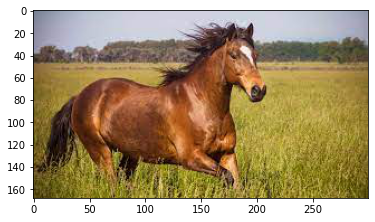


horse2.jpeg: Predicted Class = 0 => Horse


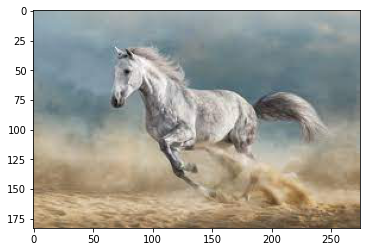


horse3.jpeg: Predicted Class = 0 => Horse


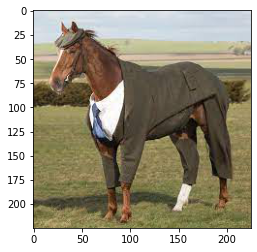


horse-human.jpeg: Predicted Class = 0 => Horse


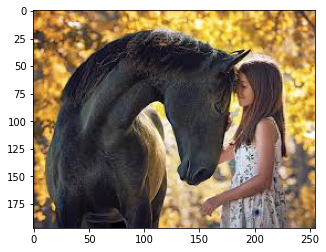


horse4.jpeg: Predicted Class = 0 => Horse


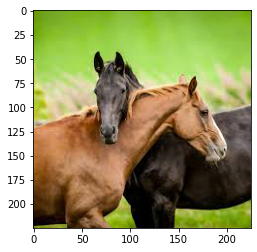


human1.jpeg: Predicted Class = 1 => Human


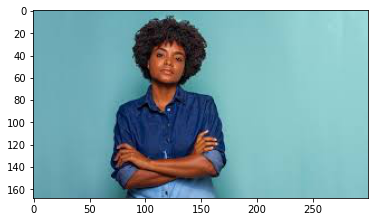


human2.jpeg: Predicted Class = 1 => Human


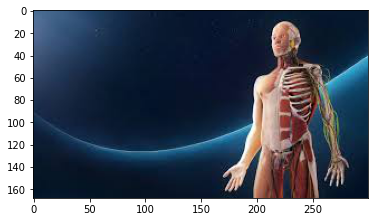


human3.jpeg: Predicted Class = 0 => Horse


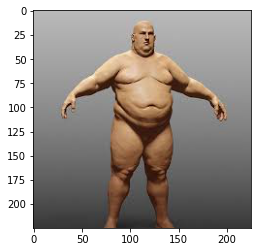

In [20]:
import numpy as np
from keras.preprocessing import image

model = model_1
images = os.listdir(PROJECT_ROOT +"/images")

for i in images:
  path = PROJECT_ROOT +"/images/" + i
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print()
  if classes[0]>0.5:
    print(i + f": Predicted Class = {int(classes[0][0])} => Human")
  else:
    print(i + f": Predicted Class = {int(classes[0][0])} => Horse") 
  plt.imshow(mpimg.imread(path))
  plt.show()

<a name='7'></a>
## 7 - Visualize Intermediate Representations

To get a feel for what kind of features our convnet has learned, we are going to visualize how an input gets transformed as it goes through the CNN.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


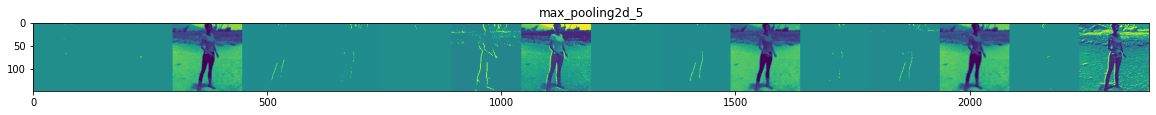

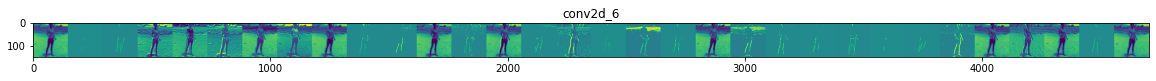

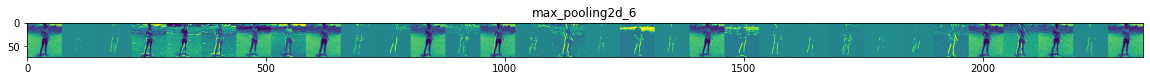

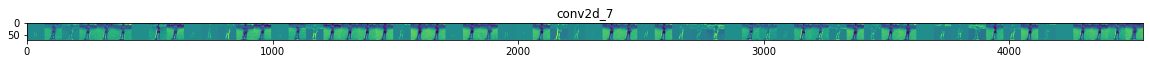

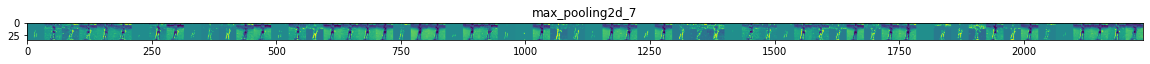

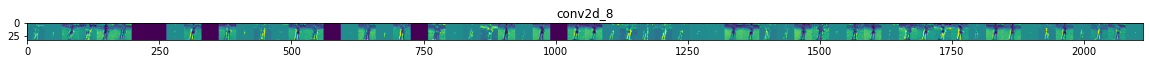

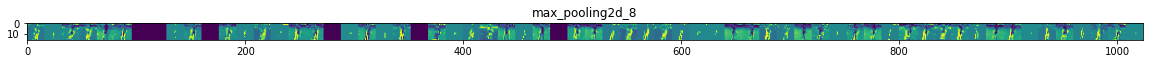

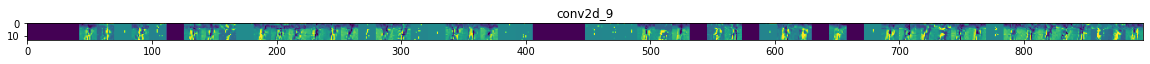

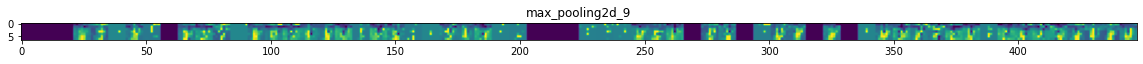

In [27]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.